In [1]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import classification_report

# 1. Classification Neural Network

## 1.1 Load Data

In [2]:
# Define filepath
file_path = os.path.join(os.path.dirname(os.getcwd()), 'data', 'Credit_Card_Fraud')
file_name = 'creditcard.csv'

In [3]:
# Load csv data
df_credit = pd.read_csv(os.path.join(file_path, file_name), sep=',', encoding='utf-8')

## 1.2 Check Data

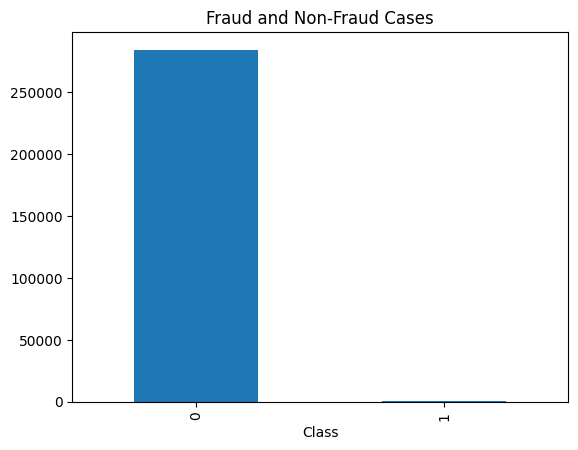

In [4]:
# Plot labels
df_credit['Class'].value_counts().plot(kind='bar')
plt.title('Fraud and Non-Fraud Cases')
plt.show()

## 1.2 Train and Test Split

In [5]:
# Drop Time column
df_credit.drop('Time', axis=1, inplace=True)

In [6]:
# Create features and labels
X = np.array(df_credit.drop('Class', axis=1))
y = np.array(df_credit['Class'])

In [7]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

In [9]:
# Split data
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, stratify=y_train_full, random_state=42)

## 1.3 Build Model

In [10]:
# set up code agnostic code so code could be run if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [11]:
# 1. Construct a model that subclasses nn.Module
class CreditCardModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        # 2. Create 3 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=input_size, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # Non Linear Activation Function
        
    # 3. Define forward method that outlines the forward pass
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [12]:
# 4. Instantiate an instance of our model class and send to target device
len_input_features = len(X_train[0])
model = CreditCardModel(len_input_features).to(device)

In [13]:
# Loss function
loss_fn = nn.BCEWithLogitsLoss() # sigmoid activation function build in
# Optimizer
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

c:\Users\lukas\anaconda3\envs\pytorch_gpu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
# Create random seed
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # Forward Pass
    y_logits = model(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    correct_train = torch.eq(y_train, y_pred).sum().item()
    acc_train = (correct_train / len(y_pred)) * 100 

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()   

    ### Testing
    model.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      correct_test = torch.eq(y_test, test_pred).sum().item()
      acc_test = (correct_test / len(test_pred)) * 100 

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc_train:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {acc_test:.2f}%")

Epoch: 0 | Loss: 0.07409, Accuracy: 99.83% | Test Loss: 0.06798, Test Accuracy: 99.83%
Epoch: 10 | Loss: 0.06784, Accuracy: 99.83% | Test Loss: 0.06236, Test Accuracy: 99.83%
Epoch: 20 | Loss: 0.06189, Accuracy: 99.83% | Test Loss: 0.05700, Test Accuracy: 99.83%
Epoch: 30 | Loss: 0.05622, Accuracy: 99.83% | Test Loss: 0.05189, Test Accuracy: 99.83%
Epoch: 40 | Loss: 0.05113, Accuracy: 99.83% | Test Loss: 0.04709, Test Accuracy: 99.83%
Epoch: 50 | Loss: 0.04628, Accuracy: 99.83% | Test Loss: 0.04256, Test Accuracy: 99.83%
Epoch: 60 | Loss: 0.04159, Accuracy: 99.83% | Test Loss: 0.03830, Test Accuracy: 99.83%
Epoch: 70 | Loss: 0.03807, Accuracy: 99.83% | Test Loss: 0.03521, Test Accuracy: 99.83%
Epoch: 80 | Loss: 0.03493, Accuracy: 99.83% | Test Loss: 0.03239, Test Accuracy: 99.83%
Epoch: 90 | Loss: 0.03215, Accuracy: 99.83% | Test Loss: 0.02987, Test Accuracy: 99.83%


In [20]:
# Generate classification report
classification_rep = classification_report(test_pred, y_test)

# Print classification report
print("Classification Report:")
print(classification_rep)

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     56962
         1.0       0.00      0.00      0.00         0

    accuracy                           1.00     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      1.00      1.00     56962



c:\Users\lukas\anaconda3\envs\pytorch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lukas\anaconda3\envs\pytorch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\lukas\anaconda3\envs\pytorch_gpu\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
